<a href="https://colab.research.google.com/github/Nirika-Lamichhane/Minor_Project-5-24-25-36-/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords


In [3]:
nltk.download('stopwords')
df = pd.read_csv('english_comments.txt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
default_stopwords = set(stopwords.words('english'))
sentiment_preserving_words = {'not', 'no', 'nor', 'but', 'only', 'very', 'too', 'again','however','although', 'against'}
custom_stopwords = default_stopwords - sentiment_preserving_words

In [5]:
import re

def preprocess_no_stop(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>|@\w+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    # Logic: Remove stopwords but keep 'not'
    words = [w for w in words if w not in custom_stopwords or w == 'not']
    return " ".join(words)

def preprocess_with_stop(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+|<.*?>|@\w+', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

In [6]:
df['text_no_stop'] = df['sentence'].apply(preprocess_no_stop)
df['text_with_stop'] = df['sentence'].apply(preprocess_with_stop)
# 3. VERIFICATION
print("--- PREPROCESSING COMPARISON ---")
print(f"Original:  {df['sentence'].iloc[59]}")
print(f"No Stop:   {df['text_no_stop'].iloc[59]}")
print(f"With Stop: {df['text_with_stop'].iloc[59]}")

--- PREPROCESSING COMPARISON ---
Original:  digital registration laws for global platforms need to be fair and not suppressive tools
No Stop:   digital registration laws global platforms need fair not suppressive tools
With Stop: digital registration laws for global platforms need to be fair and not suppressive tools


In [7]:
import spacy

# 1. Load the English model
# If this gives an error, run a new cell with: !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_pipe(text):
    # This turns the string into a spaCy 'Doc' object
    doc = nlp(text)
    # We join the base form (lemma_) of every token back into a sentence
    return " ".join([token.lemma_ for token in doc])

# 2. Apply to BOTH tracks to maintain our A/B test
print("Processing Lemmatization... (this may take a minute)")
df['lemma_no_stop'] = df['text_no_stop'].apply(lemmatize_pipe)
df['lemma_with_stop'] = df['text_with_stop'].apply(lemmatize_pipe)

# 3. Final Preprocessing Verification
print("\n--- FINAL PREPROCESSED OUTPUT (Index 59) ---")
print(f"Original:    {df['sentence'].iloc[9]}")
print(f"Track A (No Stop + Lemma):   {df['lemma_no_stop'].iloc[9]}")
print(f"Track B (With Stop + Lemma): {df['lemma_with_stop'].iloc[9]}")

Processing Lemmatization... (this may take a minute)

--- FINAL PREPROCESSED OUTPUT (Index 59) ---
Original:    nepal is now going to be the next bangladesh if leaders don't change
Track A (No Stop + Lemma):   nepal go next bangladesh leader do not change
Track B (With Stop + Lemma): nepal be now go to be the next bangladesh if leader do not change


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Initialize Tokenizers
# num_words=2000 means we only keep the top 2000 most frequent words
tokenizer_no_stop = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer_with_stop = Tokenizer(num_words=2000, oov_token="<OOV>")

# 2. Fit on the data (Build the dictionary)
tokenizer_no_stop.fit_on_texts(df['lemma_no_stop'])
tokenizer_with_stop.fit_on_texts(df['lemma_with_stop'])

# 3. Convert sentences to sequences of numbers
# e.g., "not good" -> [15, 42]
seq_no_stop = tokenizer_no_stop.texts_to_sequences(df['lemma_no_stop'])
seq_with_stop = tokenizer_with_stop.texts_to_sequences(df['lemma_with_stop'])

# 4. Padding (Step 7 of your research)
# We make every sequence the same length (e.g., 50 words) so the CNN can process them
max_length = 50
X_no_stop = pad_sequences(seq_no_stop, maxlen=max_length, padding='post')
X_with_stop = pad_sequences(seq_with_stop, maxlen=max_length, padding='post')

print("--- NUMERICAL CONVERSION CHECK ---")
print(f"Text: {df['lemma_no_stop'].iloc[0]}")
print(f"Numerical Sequence: {X_no_stop[0]}")
print(f"Text: {df['lemma_with_stop'].iloc[0]}")
print(f"Numerical Sequence: {X_with_stop[0]}")


--- NUMERICAL CONVERSION CHECK ---
Text: year rule monarchy but still poor contry world
Numerical Sequence: [ 195  299  300   74   39   75 1103  301    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
Text: over more than   year rule monarchy but still poor contry in the world
Numerical Sequence: [ 580   61  174  226  337  338   97   57   98 1176    8    2  339    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [9]:
# 1. Download the GloVe 6B (6 billion tokens) zip file
!wget http://nlp.stanford.edu/data/glove.6B.zip

# 2. Unzip it to get the 100-dimensional version
!unzip -q glove.6B.zip

--2026-01-17 13:38:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-01-17 13:38:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-01-17 13:38:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
import numpy as np

# 1. Create a dictionary to hold ALL GloVe vectors (from the file)
embeddings_index = {}
# We use the 100-dimensional version
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors in GloVe.")

# 2. Create a Matrix for YOUR specific vocabulary
# We add +1 because the 0 index is reserved for padding
vocab_size = len(tokenizer_no_stop.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer_no_stop.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words found in GloVe get the vector, others stay as zeros
        embedding_matrix[i] = embedding_vector

print(f"Embedding Matrix created with shape: {embedding_matrix.shape}")

Found 400000 word vectors in GloVe.
Embedding Matrix created with shape: (1424, 100)


In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Initialize the encoder
encoder = LabelEncoder()

# 2. Convert text labels to integers (0, 1, 2)
# Make sure 'sentiment' matches your column name in the CSV
df['label_int'] = encoder.fit_transform(df['sentiment'])

# 3. Convert integers to One-Hot Vectors (e.g., [1,0,0], [0,1,0], etc.)
y = to_categorical(df['label_int'])

# Check the mapping so you know which number is which sentiment
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(f"Label Mapping: {mapping}")
print(f"Shape of target y: {y.shape}")

Label Mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Shape of target y: (837, 3)


In [13]:
from sklearn.model_selection import train_test_split

# Split the sequences (X_no_stop) and the labels (y)
X_train, X_test, y_train, y_test = train_test_split(
    X_no_stop, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total training comments: {len(X_train)}")
print(f"Total testing comments: {len(X_test)}")

Total training comments: 669
Total testing comments: 168


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Input

model = Sequential([
    # This 'Input' layer tells the model: "Expect 50 numbers at a time"
    Input(shape=(50,)),

    # 1. Embedding Layer
    Embedding(input_dim=vocab_size,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False),

    # 2. CNN Layer
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # 3. BiLSTM Layer
    Bidirectional(LSTM(64)),

    # 4. Dense Layers
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now the summary will be fully "built" and show all shapes!
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 100)        │       142,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 128)        │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,971 (1.08 MB)

 Trainable params: 141,571 (553.01 KB)

 Non-trainable params: 142,400 (556.25 KB)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.4442 - loss: 1.0318 - val_accuracy: 0.4940 - val_loss: 0.8822
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6366 - loss: 0.7860 - val_accuracy: 0.7560 - val_loss: 0.6106
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.7934 - loss: 0.5200 - val_accuracy: 0.8274 - val_loss: 0.4569
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8653 - loss: 0.3697 - val_accuracy: 0.8690 - val_loss: 0.4151
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9428 - loss: 0.1805 - val_accuracy: 0.8869 - val_loss: 0.3735
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9674 - loss: 0.1157 - val_accuracy: 0.8988 - val_loss: 0.4220
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9727 - loss: 0.0947 - val_accuracy: 0.8929 - val_loss: 0.3730
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9598 - loss: 0.0903 - val_accuracy: 0.8631 - v

In [18]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

Final Test Accuracy: 90.48%
Final Test Loss: 0.4395


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


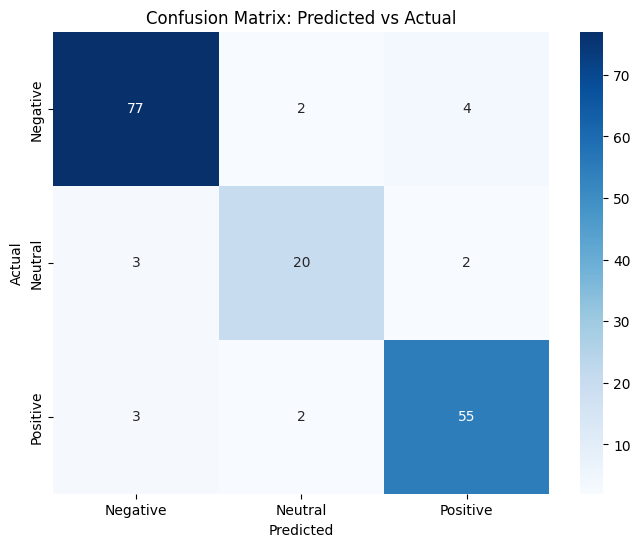


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Negative       0.93      0.93      0.93        83
     Neutral       0.83      0.80      0.82        25
    Positive       0.90      0.92      0.91        60

    accuracy                           0.90       168
   macro avg       0.89      0.88      0.88       168
weighted avg       0.90      0.90      0.90       168



In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true_classes, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix: Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. Print Precision, Recall, and F1-Score
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

In [20]:
def analyze_nepal_comment(text):
    # Process the text exactly like we did for training
    seq = tokenizer_no_stop.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=50, padding='post')

    # Predict
    pred = model.predict(padded)
    sentiment = encoder.classes_[np.argmax(pred)]
    confidence = np.max(pred) * 100

    print(f"Comment: {text}")
    print(f"Sentiment: {sentiment} ({confidence:.2f}% confidence)")

# Test it!
analyze_nepal_comment("The corruption in politics is slowing down Nepal's progress.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Comment: The corruption in politics is slowing down Nepal's progress.
Sentiment: Negative (99.36% confidence)
